# Analyzing inertial parameter estimation in simulation
## Read Text file and make variables

In [1]:
#!/usr/bin/env python3

# read text files

import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal, fftpack
from scipy.signal import savgol_filter
%matplotlib inline

# enter data file here

data_file = "data_file_03-29-19_18-16-29"
# info about data_file_03-14-19_12-55-13
# RLS controller drawing circles
# correct estimation m,com, wrong inertia
# gravity included

# info about data_file_03-14-19_15-17-59
# Trajectory testing with sin yaxis
# gravity included
# wrong estimation m,com,inertia T

# info about data_file_03-14-19_15-21-49
# RLS controller with sin yaxis
# gravity removed
# right estimation m, wrong com,inertia

# info about data_file_03-14-19_16-12-11
# RLS controller with sin yaxis + move up and down
# gravity removed
# right estimation m,com wrong inertia

# info about data_file_03-14-19_20-57-06
# estimation controller with sin yaxis + move up and down
# gravity removed
# right estimation m,com wrong inertia


path = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"

# path = "/home/elenakern/Codes/sai2.0/applications/data_collection/simulation/inertial_params_est/"
path_data_file = path + data_file

file = np.loadtxt(path_data_file,skiprows=1)

pos             = file[0::,0:3]     #position (end-effector in last link frame)
vel             = file[0::,3:6]     #linear velocity (end-effector in last link frame)
accel           = file[0::,6:9]     #linear acceleration (end-effector in last link frame)
ori             = file[0::,9:13]    #orientation in quaternions (end-effector in last link frame)
avel            = file[0::,13:16]   #angular velocity (end-effector in last link frame)
aaccel          = file[0::,16:19]   #angular acceleration (end-effector in last link frame)
force_virtual   = file[0::,19:22]   #virtual force simulation
torque_virtual  = file[0::,22:25]   #virtual torque simulation
phi_RLS         = file[0::,25:35]   #inertial parameters RLS
# phi_LS          = file[0::,35:45]   #inertial parameters LS
# phi_debug       = file[0::,45:55]   #inertial parameters direct functs


#files until data_file_03-14-19_20-57-06
# accel           = file[0::,0:3]     #linear acceleration (end-effector in last link frame)
# avel            = file[0::,3:6]     #angular velocity (end-effector in last link frame)
# aaccel          = file[0::,6:9]     #angular acceleration (end-effector in last link frame)
# g_local         = file[0::,9:12]    #gravity vector (end-effector in last link frame)
# force_virtual   = file[0::,12:15]   #virtual force simulation
# torque_virtual  = file[0::,15:18]   #virtual torque simulation
# phi             = file[0::,18:28]   #inertial parameters
# mass            = file[0::,18:19]   #estimated mass
# center_of_mass  = file[0::,19:22]   #estimated center of mass
# inertial_tensor = file[0::,22:28]   #estimated inertia tensor

time = np.arange(np.size(accel[:,0]))
time = time/1000




phi_aux = phi_RLS
phi_aux[:,1] /= phi_aux[:,0]
phi_aux[:,2] /= phi_aux[:,0]
phi_aux[:,3] /= phi_aux[:,0]

print(np.shape(phi_RLS[:,0]))
print(np.size(phi_RLS[:,0]))

aux = np.ones(np.shape(phi_RLS[:,0]))
mse_1 = np.empty_like(phi_RLS)
mse_2 = np.empty_like(phi_RLS)
mse_1[:,0] = (np.square(phi_RLS[:,0] - 2.0*aux)).mean(axis=0)
print(mse_1[:,0])
mse_1[0,0] = (np.square(phi_RLS[0,0] - 2.0)).mean(axis=None)
print(mse_1[:,0])
print(np.square(phi_RLS[0,0]-2.0).mean())

real_values = np.array([2.0,0.02, 0.03, 0.2, 0.5, 0.0,0.0,0.5,0.0,0.5])
for idx,value in enumerate(real_values):                           #for all 10 inertial params  
    for i in np.arange(np.size(phi_RLS[:,0])):                       #elementwise 
        mse_2[i,idx] = (np.square(phi_RLS[i,idx] - value)).mean(axis=None) #mean squared error
print(mse_2[:,0])

print(phi_RLS[:,0])



(10923,)
10923
[0.48995676 0.48995676 0.48995676 ... 0.48995676 0.48995676 0.48995676]
[0.489944   0.48995676 0.48995676 ... 0.48995676 0.48995676 0.48995676]
0.4899440015999999
[0.489944 0.489944 0.489944 ... 0.489958 0.489958 0.489958]
[1.30004 1.30004 1.30004 ... 1.30003 1.30003 1.30003]


## Plotting functions
### TUM colors

In [2]:
#TUM colors rgb
blue = (0,0.3961,0.7412)
red = (0.7686,0.0275,0.1059)
green =(0,0.4863,0.1882)
orange =  (0.8902, 0.4471, 0.1333)
purple = (0.4118, 0.0314, 0.3529)
grey = (0.6118, 0.6157, 0.6235)
yellow = (0.9765, 0.7294, 0)

arr1 = np.arange(0,4,1)
print(arr1)


[0 1 2 3]


### Function definitions

In [3]:
def Plot_three_dim(time, data, ylabel, title, subtitle):
    f, axarr = plt.subplots(3,1,figsize=(7,9))
    f.suptitle(title, fontsize=20)
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx].plot(time, data[:,idx], c=blue)
        axarr[idx].set_title(subtitle+str(coordinate))
        axarr[idx].set_xlim([0, time[-1]])
        axarr[idx].set_ylabel(ylabel)
    axarr[2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_one(time, data,estimation_approach):
    f, axarr = plt.subplots(10,1,figsize=(6,15))
    f.suptitle("Inertial Parameter Estimation " + estimation_approach, fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data[:,1] /= data[:,0]
    data[:,2] /= data[:,0]
    data[:,3] /= data[:,0]
    for idx, param in enumerate(params):
        axarr[idx].plot(time, data[:,idx], c=blue)
        axarr[idx].set_title(param)
        axarr[idx].set_xlim([0, time[-1]])
    axarr[9].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_one_error(time, data,estimation_approach,  m, com_x, com_y, com_z, I_xx, I_xy,I_xz, I_yy, I_yz, I_zz):
    f, axarr = plt.subplots(10,1,figsize=(6,15))
    f.suptitle("Inertial Parameter Estimation error " + estimation_approach, fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data[:,1] /= data[:,0]
    data[:,2] /= data[:,0]
    data[:,3] /= data[:,0]
    mse = np.empty_like(data)
    real_values = np.array([m, com_x,com_y,com_z, I_xx,I_xy,I_xz,I_yy,I_yz,I_zz])
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data[:,0])):                       #elementwise 
            mse[i,idx] = (np.square(data[i,idx] - value)).mean(axis=None)
    for idx, param in enumerate(params):
        axarr[idx].plot(time, mse[:,idx], c=blue)
        axarr[idx].set_title(param)
        axarr[idx].set_xlim([0, time[-1]])
    axarr[9].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_two(time, data_1,estimation_approach_1, data_2,estimation_approach_2):
    f, axarr = plt.subplots(10,2,figsize=(10,15))
    f.suptitle("Inertial Parameter Estimation ", fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, data_1[:,idx], c=blue)
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, data_2[:,idx], c=red)
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    axarr[0,0].set_title(estimation_approach_1)
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[0,1].set_title(estimation_approach_2)
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
def Plot_intertial_params_three(time, data_1,estimation_approach_1, data_2,estimation_approach_2, data_3,estimation_approach_3):
    f, axarr = plt.subplots(10,3,figsize=(15,15))
    f.suptitle("Inertial Parameter Estimation ", fontsize=20)
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    data_3[:,1] /= data_3[:,0]
    data_3[:,2] /= data_3[:,0]
    data_3[:,3] /= data_3[:,0]
    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, data_1[:,idx], c=blue, label = estimation_approach_1)
        axarr[0,0].legend()
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, data_2[:,idx], c=red, label = estimation_approach_2)
        axarr[0,1].legend()
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,2].plot(time, data_3[:,idx], c=green ,label = estimation_approach_3)
        axarr[0,2].legend()
        axarr[idx,2].set_title(param)
        axarr[idx,2].set_xlim([0, time[-1]])
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    axarr[9,2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    

def Plot_intertial_params_three_errors(time, data_1,estimation_approach_1, data_2,estimation_approach_2, data_3,estimation_approach_3, m, com_x, com_y, com_z, I_xx, I_xy,I_xz, I_yy, I_yz, I_zz):
    f, axarr = plt.subplots(10,3,figsize=(15,15))
    f.suptitle("Inertial Parameter Estimation error", fontsize=20)
    params = ['Mass error', 'COM_x error','COM_y error', 'COM_z error', '$I_{xx}$ error','$I_{xy}$ error', '$I_{xz}$ error','$I_{yy}$ error','$I_{yz}$ error','$I_{zz}$ error']
    data_1[:,1] /= data_1[:,0]
    data_1[:,2] /= data_1[:,0]
    data_1[:,3] /= data_1[:,0]
    data_2[:,1] /= data_2[:,0]
    data_2[:,2] /= data_2[:,0]
    data_2[:,3] /= data_2[:,0]
    data_3[:,1] /= data_3[:,0]
    data_3[:,2] /= data_3[:,0]
    data_3[:,3] /= data_3[:,0]
    
    mse_1 = np.empty_like(data_1)
    mse_2 = np.empty_like(data_1)
    mse_3 = np.empty_like(data_1)
    
    real_values = np.array([m, com_x,com_y,com_z, I_xx,I_xy,I_xz,I_yy,I_yz,I_zz])
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_1[:,0])):                       #elementwise 
            mse_1[i,idx] = (np.square(data_1[i,idx] - value)).mean(axis=None)
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_2[:,0])):                       #elementwise 
            mse_2[i,idx] = (np.square(data_2[i,idx] - value)).mean(axis=None)
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data_3[:,0])):                       #elementwise 
            mse_3[i,idx] = (np.square(data_3[i,idx] - value)).mean(axis=None)
    
            

    for idx, param in enumerate(params):
        axarr[idx,0].plot(time, mse_1[:,idx], c=blue, label = estimation_approach_1)
        axarr[0,0].legend()
        axarr[idx,0].set_title(param)
        axarr[idx,0].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,1].plot(time, mse_2[:,idx], c=red, label = estimation_approach_2)
        axarr[0,1].legend()
        axarr[idx,1].set_title(param)
        axarr[idx,1].set_xlim([0, time[-1]])
    for idx, param in enumerate(params):
        axarr[idx,2].plot(time, mse_3[:,idx], c=green ,label = estimation_approach_3)
        axarr[0,2].legend()
        axarr[idx,2].set_title(param)
        axarr[idx,2].set_xlim([0, time[-1]])
    axarr[9,0].set_xlabel("Elapsed time in $s$")
    axarr[9,1].set_xlabel("Elapsed time in $s$")
    axarr[9,2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
  
    
def Plot_one_dim(time, data, ylabel, title):
    plt.plot(time, data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Elapsed time in $s$")
    
def Plot_quaternions(time, quaternions):
    w = quaternions[:,0]
    x = quaternions[:,1]
    y = quaternions[:,2]
    z = quaternions[:,3]
    f, axarr = plt.subplots(2,2,figsize=(9,9))
    f.suptitle("Orientation represented as Unit Quaternions" , fontsize=20)
    axarr[0,0].plot(time, w, c=blue)
    axarr[0,0].set_title("$q_w$")
    axarr[0,0].set_xlim([0, time[-1]])
    axarr[0,1].plot(time, x, c=blue)
    axarr[0,1].set_title("$q_x$")
    axarr[0,1].set_xlim([0, time[-1]])
    axarr[1,0].plot(time, y, c=blue)
    axarr[1,0].set_title("$q_y$")
    axarr[1,0].set_xlim([0, time[-1]])
    axarr[1,0].set_xlabel("Elapsed time in s")
    axarr[1,1].plot(time, z, c=blue)
    axarr[1,1].set_title("$q_z$")
    axarr[1,1].set_xlim([0, time[-1]])
    axarr[1,1].set_xlabel("Elapsed time in s")
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)


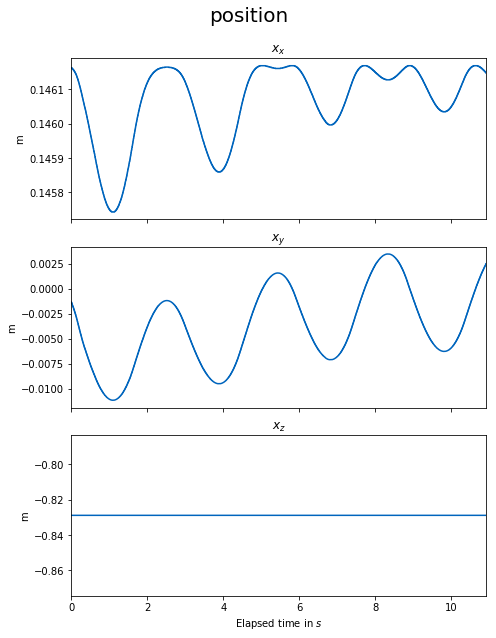

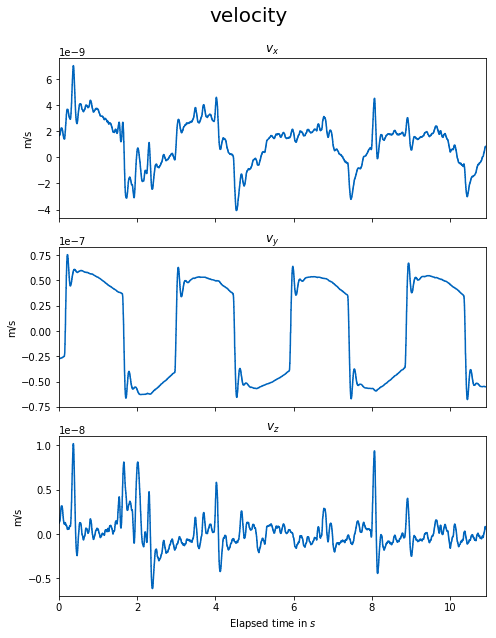

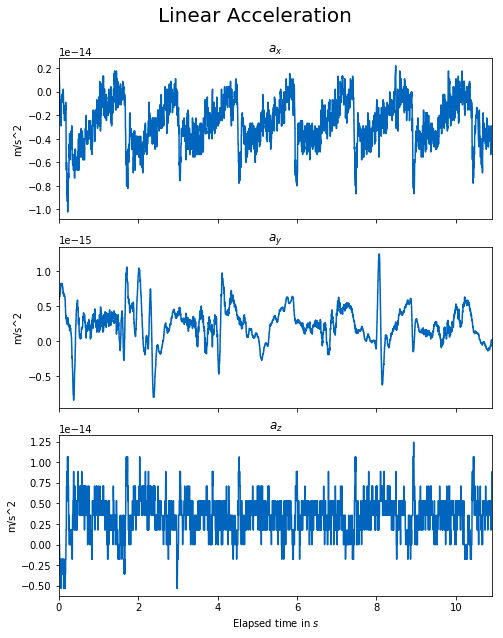

In [4]:
Plot_three_dim(time, pos, 'm',"position", "$x$")
Plot_three_dim(time, vel, 'm/s',"velocity", "$v$")
Plot_three_dim(time, accel, 'm/s^2',"Linear Acceleration", "$a$")

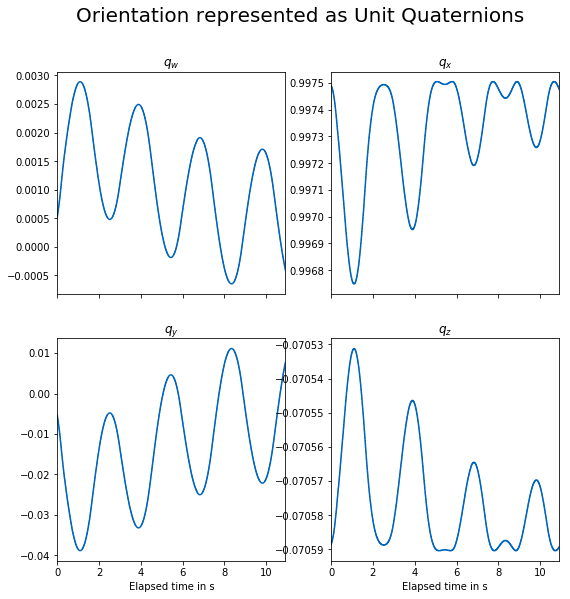

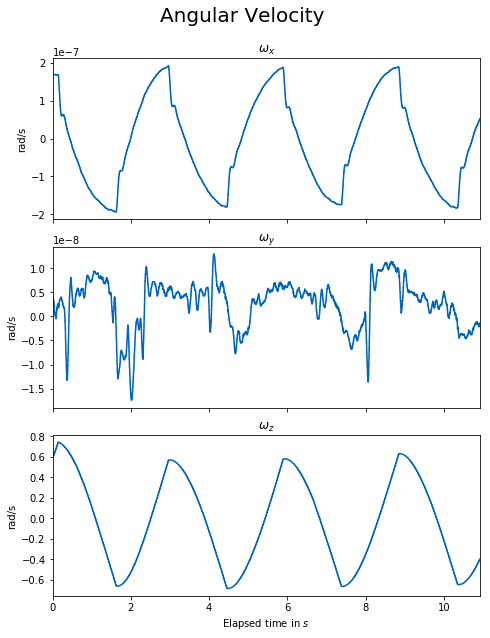

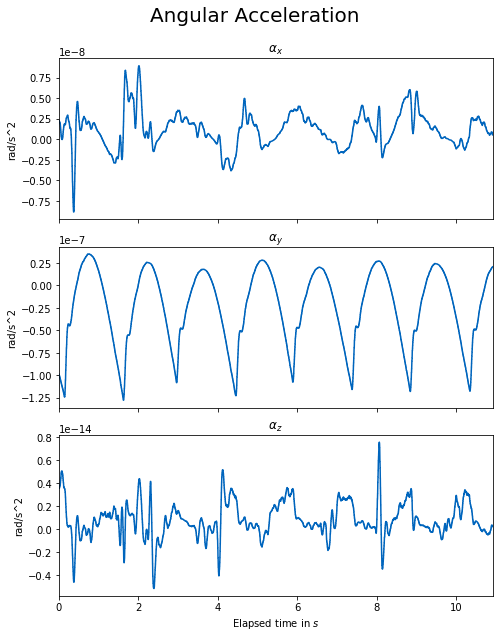

In [5]:
Plot_quaternions(time, ori)
Plot_three_dim(time, avel, 'rad/s', "Angular Velocity", "$\omega$")
Plot_three_dim(time, aaccel, 'rad/s^2', "Angular Acceleration", r"$\alpha$")

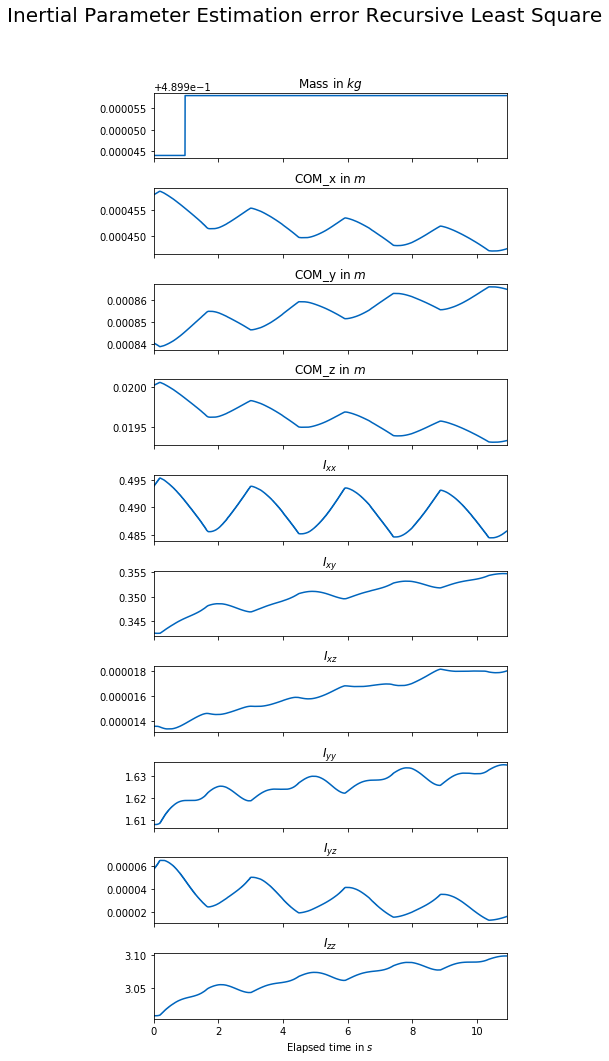

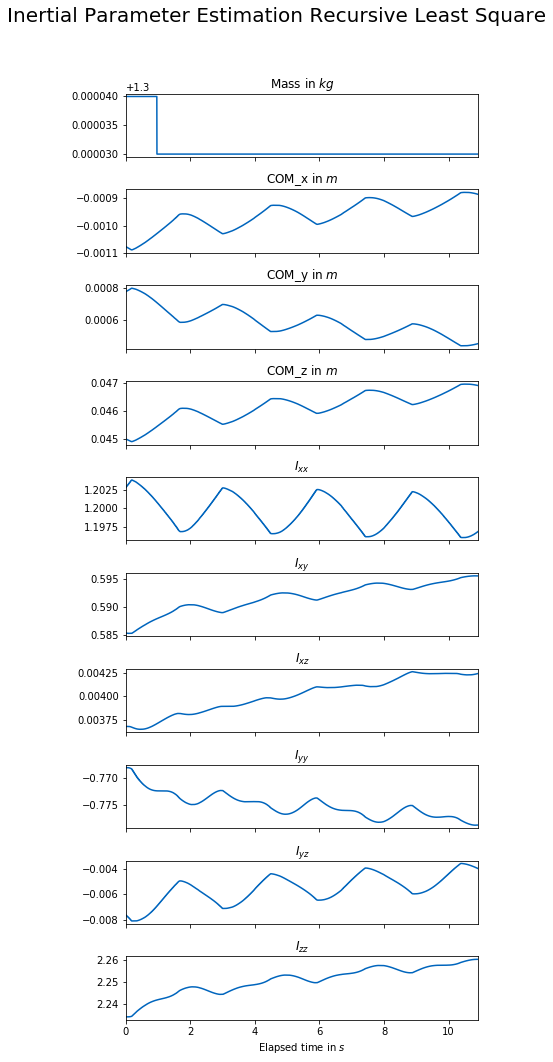

In [6]:
Plot_intertial_params_one_error (time, phi_RLS, "Recursive Least Square",2.0, 0.02 ,0.03, 0.2, 0.5, 0.0, 0.0, 0.5, 0.0, 0.5)
Plot_intertial_params_one(time, phi_RLS, "Recursive Least Square")

In [7]:
Plot_intertial_params_three_errors(time, phi_RLS, "Recursive Least Square", phi_LS, "Least Square", phi_debug, "debug",2.0, 0.02 ,0.03, 0.2, 0.5, 0.0, 0.0, 0.5, 0.0, 0.5)
Plot_intertial_params_three(time, phi_RLS, "Recursive Least Square", phi_LS, "Least Square", phi_debug, "debug")


NameError: name 'phi_LS' is not defined

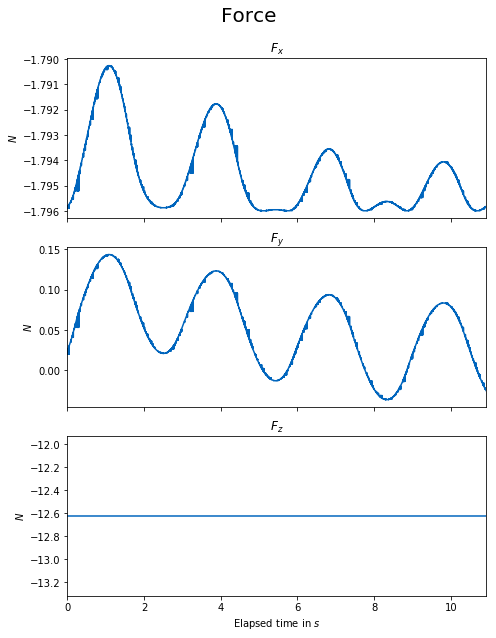

In [8]:
Plot_three_dim(time, force_virtual, '$N$', 'Force', '$F$')

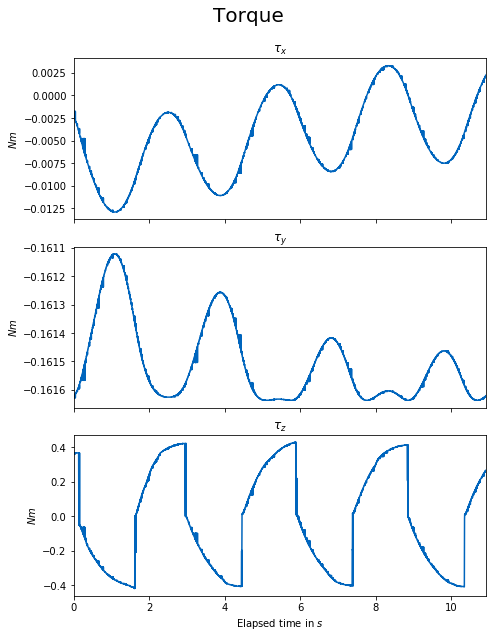

In [9]:
Plot_three_dim(time, torque_virtual, '$Nm$', 'Torque', r'$\tau$')